<h1>Path Patel 23AIML055</h1>

In [ ]:
!pip install statsmodels --quiet

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
np.random.seed(42)

In [ ]:
# Assume 10000 visitors each
n_A, p_A = 10000, 0.10
n_B ,p_B = 10000, 0.12

In [ ]:
# Simulate the number of purchases
success_A = np.random.binomial(n_A, p_A)
success_B = np.random.binomial(n_B, p_B)

In [ ]:
from typing_extensions import ParamSpecArgs
# Calculate conversion ratte
def proportion_ci(success, n, alpha=0.05):
  p_hat = success / n
  z = stats.norm.ppf(1 - alpha/2)
  std_err = np.sqrt(p_hat * (1 - p_hat)/n)
  return p_hat - z * std_err, p_hat + z * std_err, p_hat

p_A_hat,ci_low_A,ci_high_A = proportion_ci(success_A, n_A)
p_B_hat,ci_low_B,ci_high_B = proportion_ci(success_B, n_B)

results = pd.DataFrame({
    'Variant': ['A','B'],
    'Visitors:': [n_A, n_B],
    'Conversions': [success_A, success_B],
    'Conversion Rate': [p_A_hat, p_B_hat],
    'CI Lower (95%)': [ci_low_A, ci_low_B],
    'CI Upper (95%)': [ci_high_A, ci_high_B]
})

print(results)

  Variant  Visitors:  Conversions  Conversion Rate  CI Lower (95%)  \
0       A      10000          973         0.091491        0.103109   
1       B      10000         1134         0.107185        0.119615   

   CI Upper (95%)  
0          0.0973  
1          0.1134  


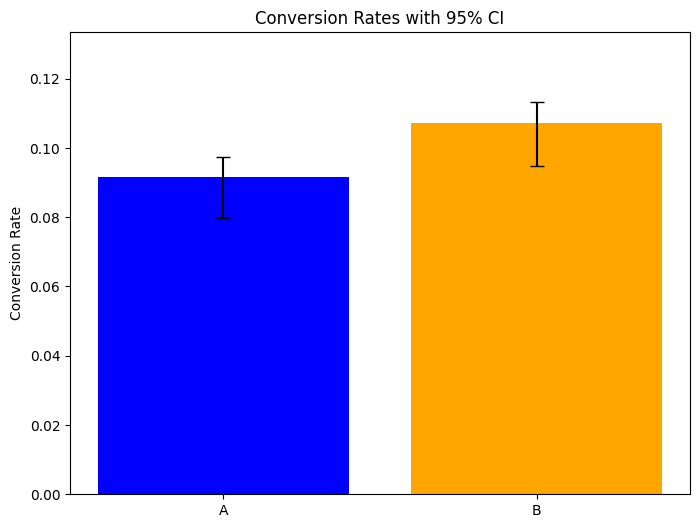

In [ ]:
plt.figure(figsize=(8, 6))

yerr = [
    results['Conversion Rate'] - results['CI Lower (95%)'],
    results['CI Upper (95%)'] - results['Conversion Rate']
]

yerr = np.abs(yerr)
plt.bar(
    results['Variant'],
    results['Conversion Rate'],
    yerr=yerr,
    capsize=5,
    color=['blue', 'orange']
)
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates with 95% CI')
plt.ylim(0, max(results['CI Upper (95%)']) + 0.02)
plt.show()

In [ ]:
# Z Proportion test

#h0 - p_B <= p_B vs h1 - p_B > p_A
count=np.array([success_A,success_B])#visitors
nobs=np.array([n_A,n_B])#conversion rate
z_stat,p_value=proportions_ztest(count,nobs)

print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_value:.3f}")

Z-statistic: -3.708
P-value: 0.000


In [ ]:
#condition for hypothesis
if p_value < 0.05:
  print("Reject the null hypothesis: Variant B has a significantly higher conversion rate.")
else:
  print("Fail to reject the null hypothesis: No significant lift from B over A.")

Reject the null hypothesis: Variant B has a significantly higher conversion rate.


In [ ]:
# Real Time Monitoring
from IPython.display import clear_output

In [ ]:
true_a_A , true_a_B = 0.10 , 0.12
batch_size = 100
n_batches = 60

# initializing counter
n_visits_A , n_visits_B = 0 , 0
n_succ_A = 0
n_succ_B = 0

# plotting list
batches = []
p_values = []
observed_lifts = []

In [ ]:
for batch in range(1, n_batches + 1):
    # Simulate one batch of visitors
    new_A = np.random.binomial(batch_size, true_a_A)
    new_B = np.random.binomial(batch_size, true_a_B)

    # Update totals
    n_visits_A += batch_size
    n_visits_B += batch_size
    n_succ_A += new_A
    n_succ_B += new_B

    # Compute conversion rates and lift
    cr_A = n_succ_A / n_visits_A
    cr_B = n_succ_B / n_visits_B
    lift = cr_B - cr_A

    # Two-proportion z-test (one-sided: B > A)
    count = np.array([n_succ_B, n_succ_A])
    nobs = np.array([n_visits_B, n_visits_A])
    z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')

    # Record for plotting
    batches.append(batch)
    p_values.append(p_val)
    observed_lifts.append(lift)

    # Display live update
    clear_output(wait=True)
    print(f"Batch {batch}/{n_batches}")
    print(f" Variant A: {n_visits_A} visits, {n_succ_A} buys → CR = {cr_A:.3%}")
    print(f" Variant B: {n_visits_B} visits, {n_succ_B} buys → CR = {cr_B:.3%}")
    print(f" Observed lift: {lift:.3%}")
    print(f" z-stat = {z_stat:.2f}, p-value = {p_val:.4f}")
    if p_val < 0.05:
        print("  Significant lift detected (p<0.05).")
    else:
        print(" No significant lift yet.")


Batch 60/60
 Variant A: 6000 visits, 574 buys → CR = 9.567%
 Variant B: 6000 visits, 714 buys → CR = 11.900%
 Observed lift: 2.333%
 z-stat = 4.13, p-value = 0.0000
  Significant lift detected (p<0.05).


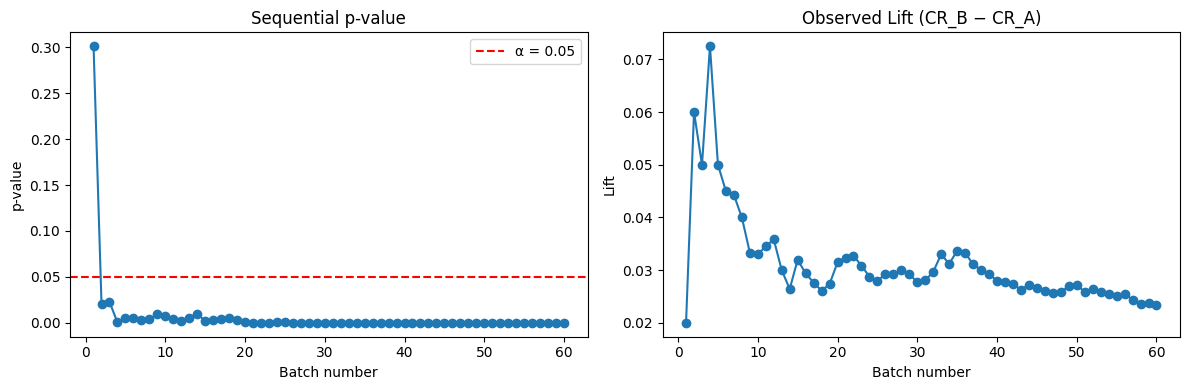

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


axes[0].plot(batches, p_values, 'o-')
axes[0].axhline(0.05, color='red', linestyle='--', label='α = 0.05')
axes[0].set_title('Sequential p-value')
axes[0].set_xlabel('Batch number')
axes[0].set_ylabel('p-value')
axes[0].legend()

axes[1].plot(batches, observed_lifts, 'o-')
axes[1].set_title('Observed Lift (CR_B − CR_A)')
axes[1].set_xlabel('Batch number')
axes[1].set_ylabel('Lift')

plt.tight_layout()
plt.show()